In [1]:
from IPython.display import display, Image, Audio
import cv2  # We're using OpenCV to read video
import base64
import time
import openai
import os
import requests

In [2]:
video = cv2.VideoCapture("data/mesi-(480p).mp4")

base64Frames = []
while video.isOpened():
    success, frame = video.read()
    if not success:
        break
    _, buffer = cv2.imencode(".jpg", frame)
    base64Frames.append(base64.b64encode(buffer).decode("utf-8"))

video.release()
print(len(base64Frames), "frames read.")

404 frames read.


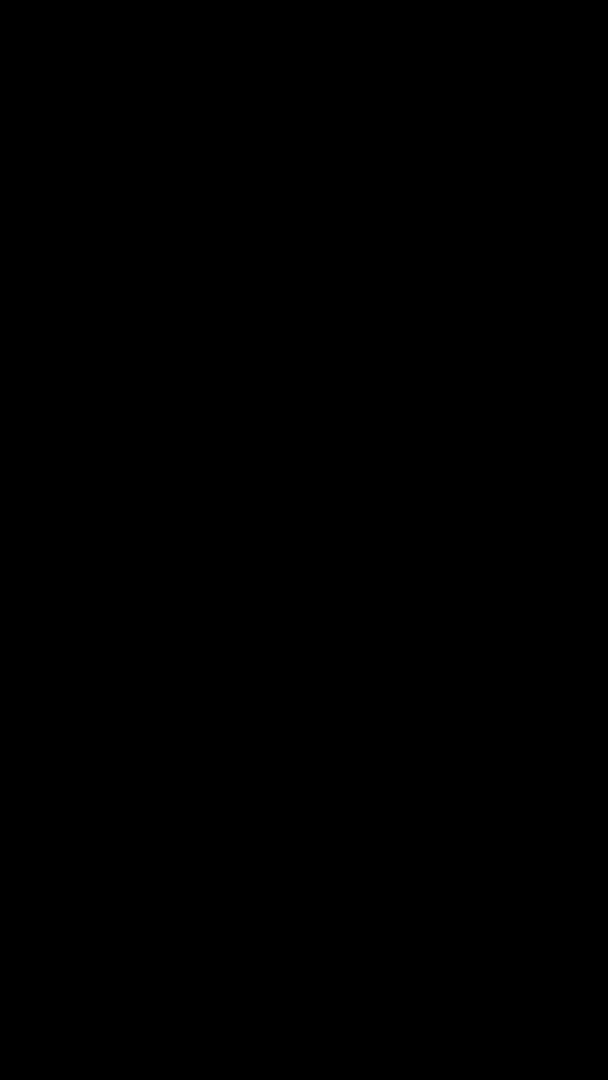

In [3]:
display_handle = display(None, display_id=True)
for img in base64Frames:
    display_handle.update(Image(data=base64.b64decode(img.encode("utf-8"))))
    time.sleep(0.025)

In [7]:
import os
import sys
from dotenv import load_dotenv

load_dotenv()


openai.api_key = os.getenv("OPENAI_API_KEY")
openai.organization = os.getenv("ORGANIZATION")
sys.path.append(os.getenv("PYTHONPATH"))


In [12]:
PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            "These are frames of a video. Create a short voiceover script in the style of a super excited brazilian sports narrator. He is a big fan of Messi, the player who scores in this clip. Use caps and exclamation marks where needed to communicate excitement. Only include the narration, your output must be in english. When the ball goes into the net, you must scream GOL either once or multiple times.",
            *map(lambda x: {"image": x, "resize": 768}, base64Frames[0::16]),
        ],
    },
]
params = {
    "model": "gpt-4-vision-preview",
    "messages": PROMPT_MESSAGES,
    "api_key": openai.api_key,
    "headers": {"Openai-Version": "2020-11-07"},
    "max_tokens": 500,
}

result = openai.ChatCompletion.create(**params)
print(result.choices[0].message.content)

AND HERE HE GOES, MESSI WITH THE BALL AT HIS FEET, HE'S A WIZARD, A MAGICIAN! HE DANCES PAST ONE DEFENDER, OH, LOOK AT HIM GO! MESSI PAST ANOTHER – THEY CAN'T TOUCH HIM! IT'S LIKE HIS FEET HAVE WINGS! HE'S APPROACHING THE GOAL AREA, THIS IS SPECTACULAR! CAN YOU BELIEVE THIS RUN?! HE SHOOTS, AND IT'S IN, IT'S IN! GOL! GOL! GOL! MESSI, YOU BEAUTIFUL GENIUS, THAT'S THE TOUCH OF A MASTER! WHAT A GOAL, LADIES AND GENTLEMEN, WHAT A GOAL!!!


In [13]:
response = requests.post(
    "https://api.openai.com/v1/audio/speech",
    headers={
        "Authorization": f"Bearer {openai.api_key}",
    },
    json={
        "model": "tts-1",
        "input": result.choices[0].message.content,
        "voice": "fable",
    },
)

audio = b""
for chunk in response.iter_content(chunk_size=1024 * 1024):
    audio += chunk
Audio(audio)

In [14]:
# ... your existing code ...

# Now, write the `audio` bytes to an MP3 file
with open('output.mp3', 'wb') as file:
    file.write(audio)

print("The MP3 file has been saved locally as 'output.mp3'.")


The MP3 file has been saved locally as 'output.mp3'.


In [7]:
from moviepy.editor import VideoFileClip, AudioFileClip
from pydub import AudioSegment
import subprocess
import io

# 동영상과 새 오디오 파일 경로 설정
video_path = "data/mesi-(480p).mp4"
new_audio_path = './output.mp3'

# 동영상과 오디오 클립 불러오기
video_clip = VideoFileClip(video_path)
video_duration = video_clip.duration
# 오디오 파일 로드
audio = AudioSegment.from_mp3(new_audio_path)


# 오디오 속도 조절을 위한 factor 계산
factor = len(audio) / (video_clip.duration * 1000.0)





In [ ]:
# ffmpeg를 사용하여 속도 조절
temp_audio_path = "temp_fast_audio.mp3"
subprocess.call([
    'ffmpeg', '-i', new_audio_path,
    '-filter:a', f"atempo={factor}",
    '-vn', temp_audio_path
])

In [ ]:


# 조절된 오디오 파일 로드
fast_audio_clip = AudioFileClip(temp_audio_path)


# 동영상에서 오리지널 오디오 제거 및 새 오디오 추가
final_clip = video_clip.set_audio(fast_audio_clip)

# 결과물 저장 (코덱 변경 없음)
final_clip.write_videofile("output_video.mp4", audio_codec='aac')